In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

from scipy.stats import spearmanr
import talib

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
deciles = np.arange(.1, 1, .1)

In [4]:
tcols = ['openbartime',
         'firsttradetime',
         'highbidtime',
         'highasktime',
         'hightradetime',
         'lowbidtime',
         'lowasktime',
         'lowtradetime',
         'closebartime',
         'lasttradetime']

In [5]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [6]:
keep = ['firsttradeprice',
        'hightradeprice',
        'lowtradeprice',
        'lasttradeprice',
        'minspread',
        'maxspread',
        'volumeweightprice',
        'nbboquotecount',
        'tradeatbid',
        'tradeatbidmid',
        'tradeatmid',
        'tradeatmidask',
        'tradeatask',
        'volume',
        'totaltrades',
        'finravolume',
        'finravolumeweightprice',
        'uptickvolume',
        'downtickvolume',
        'repeatuptickvolume',
        'repeatdowntickvolume',
        'tradetomidvolweight',
        'tradetomidvolweightrelative']

In [7]:
# shorten most of the field names to reduce typing

columns = {'volumeweightprice': 'price',
           'finravolume': 'fvolume',
           'finravolumeweightprice': 'fprice',
           'uptickvolume': 'up',
           'downtickvolume': 'down',
           'repeatuptickvolume': 'rup',
           'repeatdowntickvolume': 'rdown',
           'firsttradeprice': 'first',
           'hightradeprice': 'high',
           'lowtradeprice': 'low',
           'lasttradeprice': 'last',
           'nbboquotecount': 'nbbo',
           'totaltrades': 'ntrades',
           'openbidprice': 'obprice',
           'openbidsize': 'obsize',
           'openaskprice': 'oaprice',
           'openasksize': 'oasize',
           'highbidprice': 'hbprice',
           'highbidsize': 'hbsize',
           'highaskprice': 'haprice',
           'highasksize': 'hasize',
           'lowbidprice': 'lbprice',
           'lowbidsize': 'lbsize',
           'lowaskprice': 'laprice',
           'lowasksize': 'lasize',
           'closebidprice': 'cbprice',
           'closebidsize': 'cbsize',
           'closeaskprice': 'caprice',
           'closeasksize': 'casize',
           'firsttradesize': 'firstsize',
           'hightradesize': 'highsize',
           'lowtradesize': 'lowsize',
           'lasttradesize': 'lastsize',
           'tradetomidvolweight': 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

In [8]:
nasdaq_path = Path('../data/nasdaq100')

In [9]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'])
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [10]:
extract_and_combine_data()

100%|████████████████████████████████████████████████████████████████████████████| 80194/80194 [39:16<00:00, 34.03it/s]


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('XRAY', Timestamp('2017-12-29 16:00:00'))
Data columns (total 45 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   obprice        31355451 non-null  float64
 1   obsize         31355451 non-null  float64
 2   oaprice        31355457 non-null  float64
 3   oasize         31355457 non-null  float64
 4   first          30955838 non-null  float64
 5   firstsize      30955838 non-null  float64
 6   hbprice        31355463 non-null  float64
 7   hbsize         31355463 non-null  int32  
 8   haprice        31355463 non-null  float64
 9   hasize         31355463 non-null  int32  
 10  high           30955838 non-null  float64
 11  highsize       30955838 non-null  float64
 12  lbprice        31355463 non-null  float64
 13  lbsize         31355463 non-null  int32  
 14  laprice        31355463 non-null  float64
 15  lasize 

In [11]:
ohlcv_cols = ['first', 'high', 'low', 'last', 'price', 'volume']

In [12]:
data_cols = ohlcv_cols + ['up', 'down', 'rup', 'rdown', 'atask', 'atbid']

In [14]:
with pd.HDFStore(nasdaq_path / 'algoseek.h5') as store:
    df = store['min_taq'].loc[:, data_cols].sort_index()

In [17]:
df['date'] = pd.to_datetime(df.index.get_level_values('date_timebarstart').date)

In [19]:
df.to_hdf('data/algoseek.h5', 'data')

In [33]:
df = pd.read_hdf('data/algoseek.h5', 'data')

In [34]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 16:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count     Dtype         
---  ------  --------------     -----         
 0   first   30955838 non-null  float64       
 1   high    30955838 non-null  float64       
 2   low     30955838 non-null  float64       
 3   last    30955838 non-null  float64       
 4   price   30386944 non-null  float64       
 5   volume  31355463 non-null  int32         
 6   up      31355463 non-null  int32         
 7   down    31355463 non-null  int32         
 8   rup     31355463 non-null  int32         
 9   rdown   31355463 non-null  int32         
 10  atask   31355463 non-null  int32         
 11  atbid   31355463 non-null  int32         
 12  date    31355463 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int32(7)
memory usage: 2.4+ GB


## Feature Engineering

In [35]:
by_ticker = df.sort_index().groupby('ticker', group_keys=False)
by_ticker_date = df.sort_index().groupby(['ticker', 'date'])

Create empty DataFrame with original ticker/timestamp to hold the features

In [36]:
data = pd.DataFrame(index=df.index)

In [37]:
data['date'] = pd.factorize(df['date'], sort=True)[0]

In [40]:
data['minute'] = pd.to_timedelta(data.index.get_level_values('date_timebarstart').time.astype(str))
data.minute = (data.minute.dt.seconds.sub(data.minute.dt.seconds.min()).div(60).astype(int))

## Lagged Returns

In [41]:
data[f'ret1min'] = df['last'].div(df['first']).sub(1)

In [42]:
data

date  minute   ret1min
ticker date_timebarstart                          
AAL    2015-01-02 09:30:00     0       0  0.004241
       2015-01-02 09:31:00     0       1 -0.007896
       2015-01-02 09:32:00     0       2  0.005552
       2015-01-02 09:33:00     0       3 -0.006072
       2015-01-02 09:34:00     0       4  0.007773
...                          ...     ...       ...
YHOO   2017-06-16 15:56:00   618     386 -0.000663
       2017-06-16 15:57:00   618     387  0.001138
       2017-06-16 15:58:00   618     388  0.001894
       2017-06-16 15:59:00   618     389 -0.006051
       2017-06-16 16:00:00   618     390  0.001519

[31355463 rows x 3 columns]

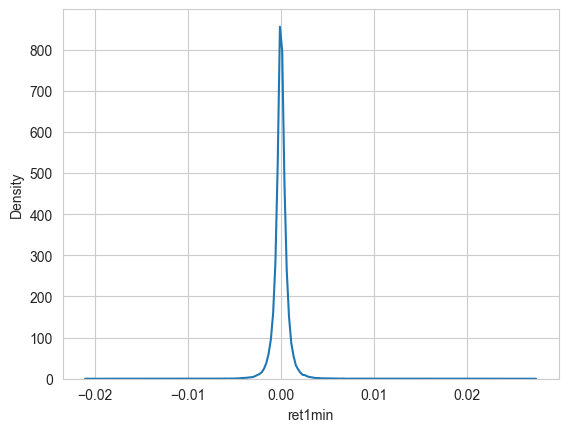

In [44]:
sns.kdeplot(data.ret1min.sample(n=100000));

In [48]:
data.ret1min.describe(percentiles=np.arange(.1, 1, .1)).iloc[1:].apply(lambda x: f'{x:.3%}')

mean     -0.000%
std       0.086%
min     -12.448%
10%      -0.075%
20%      -0.041%
30%      -0.023%
40%      -0.009%
50%       0.000%
60%       0.009%
70%       0.022%
80%       0.040%
90%       0.074%
max      13.392%
Name: ret1min, dtype: object

In [49]:
print(f'Skew: {data.ret1min.skew():.2f} | Kurtosis: {data.ret1min.kurtosis():.2f}')

Skew: 0.63 | Kurtosis: 399.53


intra-bar price moves with the highest returns:

In [50]:
data.join(df[['first', 'last']]).nlargest(10, columns=['ret1min'])

,,date,minute,ret1min,first,last
ticker,date_timebarstart,,,,,
TSCO,2016-12-22 10:01:00,498,31,0.133921,68.1000,77.2200
AMGN,2017-03-06 15:46:00,546,376,0.132842,158.7600,179.8500
LILA,2015-07-02 09:39:00,125,9,0.121998,50.0001,56.1000
BIDU,2015-08-24 09:32:00,161,2,0.119729,111.2300,124.5475
NXPI,2016-09-29 13:10:00,439,220,0.119144,81.7500,91.4900
HSIC,2015-10-26 15:38:00,205,368,0.105501,135.0700,149.3200
CELG,2015-08-24 09:35:00,161,5,0.100645,93.0000,102.3600
LILAK,2015-07-02 09:38:00,125,8,0.098778,50.0101,54.9500
CTRP,2017-12-11 10:51:00,741,81,0.097899,43.3100,47.5500


In [52]:
for t in tqdm(range(2, 11)):
    data[f'ret{t}min'] = df['last'].div(by_ticker_date['first'].shift(t-1)).sub(1)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:18<00:00,  2.03s/it]


In [53]:
data['fwd1min'] = (data
                   .sort_index()
                   .groupby(['ticker', 'date'])
                   .ret1min
                   .shift(-1))

In [58]:
data = data.dropna(subset=['fwd1min'])

In [59]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 30875649 entries, ('AAL', Timestamp('2015-01-02 09:30:00')) to ('YHOO', Timestamp('2017-06-16 15:59:00'))
Data columns (total 13 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   date      30875649 non-null  int64  
 1   minute    30875649 non-null  int32  
 2   ret1min   30612848 non-null  float64
 3   ret2min   30302846 non-null  float64
 4   ret3min   30220887 non-null  float64
 5   ret4min   30141503 non-null  float64
 6   ret5min   30063236 non-null  float64
 7   ret6min   29983969 non-null  float64
 8   ret7min   29903822 non-null  float64
 9   ret8min   29824607 non-null  float64
 10  ret9min   29745431 non-null  float64
 11  ret10min  29666821 non-null  float64
 12  fwd1min   30875649 non-null  float64
dtypes: float64(11), int32(1), int64(1)
memory usage: 3.1+ GB


## Normalized up/downtick volume

In [60]:
for f in ['up', 'down', 'rup', 'rdown']:
    data[f] = df.loc[:, f].div(df.volume).replace(np.inf, np.nan)

In [67]:
data['BOP'] = (by_ticker.apply(lambda x: alib.BOP(x['first'],
                                                 x.high,
                                                 x.low,
                                                 x['last'])))

MemoryError: Unable to allocate 1.17 GiB for an array with shape (5, 31355463) and data type float64

In [62]:
data

date  minute   ret1min   ret2min   ret3min  \
ticker date_timebarstart                                                 
AAL    2015-01-02 09:30:00     0       0  0.004241       NaN       NaN   
       2015-01-02 09:31:00     0       1 -0.007896 -0.003688       NaN   
       2015-01-02 09:32:00     0       2  0.005552 -0.002387  0.001844   
       2015-01-02 09:33:00     0       3 -0.006072 -0.000185 -0.008079   
       2015-01-02 09:34:00     0       4  0.007773  0.001840  0.007773   
...                          ...     ...       ...       ...       ...   
YHOO   2017-06-16 15:55:00   618     385 -0.000642  0.000854  0.000000   
       2017-06-16 15:56:00   618     386 -0.000663 -0.001210  0.000285   
       2017-06-16 15:57:00   618     387  0.001138  0.000474 -0.000074   
       2017-06-16 15:58:00   618     388  0.001894  0.003034  0.002369   
       2017-06-16 15:59:00   618     389 -0.006051 -0.004357 -0.003224   

                             ret4min   ret5min   ret6min   ret7min   ret8min  \
ticker date_timebarstart                                                       
AAL    2015-01-02 09:30:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:31:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:32:00       NaN       NaN       NaN       NaN       NaN   
       2015-01-02 09:33:00 -0.003872       NaN       NaN       NaN       NaN   
       2015-01-02 09:34:00 -0.000184  0.004057       NaN       NaN       NaN   
...                              ...       ...       ...       ...       ...   
YHOO   2017-06-16 15:55:00 -0.000568  0.000190  0.006102  0.008024  0.005527   
       2017-06-16 15:56:00 -0.000569 -0.001137 -0.000379  0.005530  0.007451   
       2017-06-16 15:57:00  0.001423  0.000569  0.000000  0.000758  0.006674   
       2017-06-16 15:58:00  0.001820  0.003320  0.002464  0.001894  0.002654   
       2017-06-16 15:59:00 -0.003885 -0.004430 -0.002940 -0.003791 -0.004357   

                             ret9min  ret10min   fwd1min        up      down  \
ticker date_timebarstart                                                       
AAL    2015-01-02 09:30:00       NaN       NaN -0.007896  0.120742  0.658482   
       2015-01-02 09:31:00       NaN       NaN  0.005552  0.530679  0.648497   
       2015-01-02 09:32:00       NaN       NaN -0.006072  0.617411  0.480509   
       2015-01-02 09:33:00       NaN       NaN  0.007773  0.523530  0.705808   
       2015-01-02 09:34:00       NaN       NaN -0.001470  0.391644  0.219128   
...                              ...       ...       ...       ...       ...   
YHOO   2017-06-16 15:55:00  0.003996  0.000000 -0.000663  0.124171  0.128599   
       2017-06-16 15:56:00  0.004955  0.003425  0.001138  0.096142  0.099631   
       2017-06-16 15:57:00  0.008598  0.006099  0.001894  0.059758  0.069981   
       2017-06-16 15:58:00  0.008581  0.010508 -0.006051  0.161912  0.225752   
       2017-06-16 15:59:00 -0.003602  0.002288  0.001519  0.073455  0.105046   

                                 rup     rdown  
ticker date_timebarstart                        
AAL    2015-01-02 09:30:00  0.321658  0.088409  
       2015-01-02 09:31:00  0.276688  0.605885  
       2015-01-02 09:32:00  0.688707  0.248803  
       2015-01-02 09:33:00  0.250676  0.515424  
       2015-01-02 09:34:00  0.875777  0.107958  
...                              ...       ...  
YHOO   2017-06-16 15:55:00  0.366377  0.631529  
       2017-06-16 15:56:00  0.414266  0.596307  
       2017-06-16 15:57:00  0.623827  0.365528  
       2017-06-16 15:58:00  0.494843  0.444248  
       2017-06-16 15:59:00  0.412795  0.477597  

[30875649 rows x 17 columns]